Original Grid Shape: (10, 10, 10, 3)
Deformed Grid Shape: (10, 10, 10, 3)


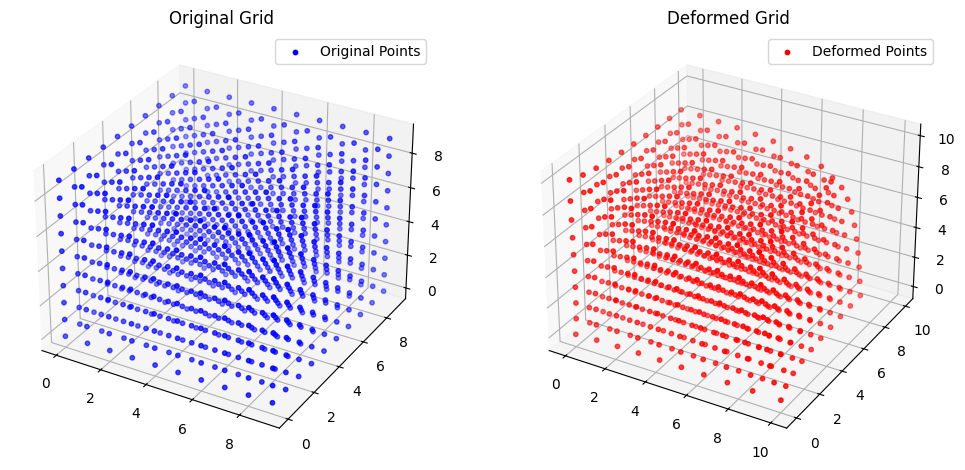

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def generate_grid(grid_size, spacing):
    """Generate a 3D grid with the specified size and spacing."""
    x = np.linspace(0, spacing * (grid_size[0] - 1), grid_size[0])
    y = np.linspace(0, spacing * (grid_size[1] - 1), grid_size[1])
    z = np.linspace(0, spacing * (grid_size[2] - 1), grid_size[2])
    grid = np.array(np.meshgrid(x, y, z, indexing="ij"))
    return grid.transpose(1, 2, 3, 0)  # Shape: (nx, ny, nz, 3)

def apply_ffd(grid, control_points, displacements):
    """Apply free-form deformation to a 3D grid.

    Args:
        grid: The original 3D grid (nx, ny, nz, 3).
        control_points: Positions of control points (k, 3).
        displacements: Displacements at each control point (k, 3).

    Returns:
        Deformed grid with the same shape as input grid.
    """
    def blend_function(grid_point, control_points):
        """Compute weights for blending the control point displacements."""
        weights = np.zeros(len(control_points))
        for i, cp in enumerate(control_points):
            distance = np.linalg.norm(grid_point - cp)
            weights[i] = 1.0 / (distance + 1e-6)  # Inverse distance weighting
        weights /= np.sum(weights)  # Normalize weights
        return weights

    deformed_grid = np.zeros_like(grid)
    for idx, point in np.ndenumerate(grid[..., 0]):
        grid_point = grid[idx]
        weights = blend_function(grid_point, control_points)
        displacement = np.dot(weights, displacements)
        deformed_grid[idx] = grid_point + displacement

    return deformed_grid

def plot_grids(original_grid, deformed_grid):
    """Plot the original and deformed 3D grids."""
    fig = plt.figure(figsize=(12, 6))

    # Original grid
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.set_title("Original Grid")
    ax1.scatter(
        original_grid[..., 0].flatten(),
        original_grid[..., 1].flatten(),
        original_grid[..., 2].flatten(),
        c='blue', s=10, label='Original Points'
    )
    ax1.legend()

    # Deformed grid
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title("Deformed Grid")
    ax2.scatter(
        deformed_grid[..., 0].flatten(),
        deformed_grid[..., 1].flatten(),
        deformed_grid[..., 2].flatten(),
        c='red', s=10, label='Deformed Points'
    )
    ax2.legend()

    plt.show()

# Example usage
grid_size = (10, 10, 10)  # Define grid size (nx, ny, nz)
spacing = 1.0  # Spacing between grid points

# Generate the initial 3D grid
original_grid = generate_grid(grid_size, spacing)

# Define control points and their displacements
control_points = np.array([
    [0, 0, 0],
    [9, 0, 0],
    [0, 9, 0],
    [0, 0, 9],
    [9, 9, 9]
])
displacements = np.array([
    [0, 0, 0],
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [-1, -1, -1]
])

# Apply the free-form deformation
deformed_grid = apply_ffd(original_grid, control_points, displacements)

# Output results
print("Original Grid Shape:", original_grid.shape)
print("Deformed Grid Shape:", deformed_grid.shape)

# Plot the grids
plot_grids(original_grid, deformed_grid)


In [2]:
import torch
import torch.nn as nn
import torch.distributions as dist

class ParticleFilter:
    def __init__(self, n_particles, state_dim, observation_dim):
        """
        Initialize particle filter
        
        Args:
            n_particles (int): Number of particles
            state_dim (int): Dimension of state space
            observation_dim (int): Dimension of observation space
        """
        self.n_particles = n_particles
        self.state_dim = state_dim
        self.observation_dim = observation_dim
        
        # Initialize particles and weights
        self.particles = torch.zeros(n_particles, state_dim)
        self.weights = torch.ones(n_particles) / n_particles
        
    def predict(self, transition_fn, noise_std=0.1):
        """
        Prediction step: propagate particles through transition model
        
        Args:
            transition_fn: Function that takes current state and returns next state
            noise_std (float): Standard deviation of transition noise
        """
        # Apply transition function to all particles
        self.particles = transition_fn(self.particles)
        
        # Add transition noise
        noise = torch.randn_like(self.particles) * noise_std
        self.particles += noise
        
    def update(self, observation, likelihood_fn):
        """
        Update step: adjust weights based on observation likelihood
        
        Args:
            observation: Current observation
            likelihood_fn: Function that computes p(observation|state)
        """
        # Compute likelihood weights
        log_weights = likelihood_fn(self.particles, observation)
        
        # Update and normalize weights
        self.weights *= torch.exp(log_weights)
        self.weights /= self.weights.sum()
        
    def resample(self, threshold=0.5):
        """
        Resample particles if effective sample size falls below threshold
        
        Args:
            threshold (float): Minimum effective sample size ratio
        """
        # Compute effective sample size
        n_eff = 1.0 / (self.weights ** 2).sum()
        n_eff_ratio = n_eff / self.n_particles
        
        if n_eff_ratio < threshold:
            # Multinomial resampling
            indices = torch.multinomial(self.weights, self.n_particles, replacement=True)
            self.particles = self.particles[indices]
            self.weights = torch.ones_like(self.weights) / self.n_particles
            
    def estimate_state(self):
        """
        Compute weighted mean of particles as state estimate
        
        Returns:
            torch.Tensor: Estimated state
        """
        return (self.particles * self.weights.unsqueeze(-1)).sum(dim=0)

# Example usage with a linear Gaussian model
def example_linear_gaussian():
    # Model parameters
    A = torch.tensor([[1.0, 1.0], [0.0, 1.0]])  # Transition matrix
    C = torch.tensor([[1.0, 0.0]])              # Observation matrix
    Q = 0.1  # Process noise
    R = 0.1  # Observation noise
    
    # Define transition and likelihood functions
    def transition_fn(states):
        return torch.matmul(states, A.t())
    
    def likelihood_fn(states, observation):
        predicted_obs = torch.matmul(states, C.t())
        return -0.5 * ((observation - predicted_obs) ** 2).sum(dim=1) / R
    
    # Initialize filter
    pf = ParticleFilter(n_particles=1000, state_dim=2, observation_dim=1)
    
    # Initialize particles from prior
    pf.particles = torch.randn(pf.n_particles, pf.state_dim)
    
    # Generate synthetic data
    true_state = torch.zeros(2)
    observation = torch.matmul(true_state.unsqueeze(0), C.t()).squeeze() + torch.randn(1) * R**0.5
    
    # Single update step
    pf.predict(transition_fn, noise_std=Q**0.5)
    pf.update(observation, likelihood_fn)
    pf.resample()
    
    estimated_state = pf.estimate_state()
    return estimated_state

In [3]:
example_linear_gaussian()

tensor([-0.1373, -0.0995])

In [21]:
import torch
import torch.nn.functional as F
import numpy as np

def linear_model(X, weights):
    """Compute predictions for a batch of particles."""
    return X @ weights.T

def likelihood(y_true, y_pred, sigma):
    """Compute likelihood of observed data given predictions."""
    # return torch.exp(-0.5 * ((y_true - y_pred) ** 2) / sigma**2) / (torch.sqrt(2 * torch.pi * sigma**2))
    return torch.exp(torch.distributions.Normal(y_pred, sigma).log_prob(y_true))

def resample(particles, weights):
    """Resample particles based on their weights."""
    indices = torch.multinomial(weights, len(weights), replacement=True)
    return particles[indices], torch.ones_like(weights) / len(weights)

class ParticleFilterBayesianLR:
    def __init__(self, n_particles, n_features, sigma_obs, resample_threshold=0.5):
        """
        Initialize the particle filter for Bayesian linear regression.

        Args:
            n_particles (int): Number of particles.
            n_features (int): Number of features (including bias term).
            sigma_obs (float): Observation noise standard deviation.
            resample_threshold (float): Threshold for resampling (ESS/N < threshold).
        """
        self.n_particles = n_particles
        self.n_features = n_features
        self.sigma_obs = sigma_obs
        self.resample_threshold = resample_threshold
        
        # Initialize particles and weights
        self.particles = torch.randn(n_particles, n_features)
        self.weights = torch.ones(n_particles) / n_particles

    def update(self, X, y):
        """Perform a single update of the particle filter with new data."""
        # Compute predictions
        y_preds = linear_model(X, self.particles)

        # Update weights using likelihood
        particle_likelihoods = likelihood(y, y_preds, self.sigma_obs).prod(dim=1)
        self.weights *= particle_likelihoods

        # Normalize weights
        self.weights /= self.weights.sum()

        # Compute effective sample size (ESS)
        ess = 1.0 / (self.weights**2).sum()

        # Resample if necessary
        if ess / self.n_particles < self.resample_threshold:
            self.particles, self.weights = resample(self.particles, self.weights)

    def predict(self, X):
        """Make predictions using the particle filter."""
        # Compute predictions for all particles
        y_preds = linear_model(X, self.particles)  # Shape: (n_samples, n_particles)
        
        # Reshape weights to (1, n_particles) for broadcasting
        weights = self.weights.view(1, -1)  # Shape: (1, n_particles)
        
        # Compute weighted average along the particle axis
        return (y_preds * weights).sum(dim=1)  # Shape: (n_samples)

# Example usage
if __name__ == "__main__":
    # Generate synthetic data
    torch.manual_seed(42)
    n_samples = 500
    n_features = 2
    true_weights = torch.tensor([2.0, -1.0])  # True weights for synthetic data
    X = torch.cat([torch.ones(n_samples, 1), torch.randn(n_samples, n_features - 1)], dim=1)
    y = X @ true_weights + 0.1 * torch.randn(n_samples)

    print(X.shape, y.shape)
    # Initialize the particle filter
    n_particles = 100
    sigma_obs = 0.1
    pf = ParticleFilterBayesianLR(n_particles, n_features, sigma_obs)

    # Update particle filter with data
    for i in range(n_samples):
        pf.update(X[i:i+1], y[i:i+1])

    # Make predictions
    y_pred = pf.predict(X)

    # Print results
    print("True weights:", true_weights)
    print("Estimated mean weights:", pf.particles.T @ pf.weights)


torch.Size([500, 2]) torch.Size([500])
True weights: tensor([ 2., -1.])
Estimated mean weights: tensor([nan, nan])


In [31]:
X = torch.tensor([[1.0, 0.0], [1.0, 1.0], [1.0, 2.0], [1.0, 3.0]])
weight = torch.tensor([[2.0, -1.0], [1.0, -2.0]])

print(X, weight)
y = X @ weight.T
print(y)

tensor([[1., 0.],
        [1., 1.],
        [1., 2.],
        [1., 3.]]) tensor([[ 2., -1.],
        [ 1., -2.]])
tensor([[ 2.,  1.],
        [ 1., -1.],
        [ 0., -3.],
        [-1., -5.]])


In [1]:
import torch
import torch.distributions as dist

# Define Beta prior parameters
alpha_prior = 2.0
beta_prior = 2.0

# Observations (0 for failure, 1 for success)
observations = torch.tensor([1, 0, 1, 1, 0, 1, 1, 0], dtype=torch.float32)

# Compute the posterior parameters
alpha_posterior = alpha_prior + observations.sum()
beta_posterior = beta_prior + len(observations) - observations.sum()

# Define the prior and posterior distributions
prior = dist.Beta(alpha_prior, beta_prior)
posterior = dist.Beta(alpha_posterior, beta_posterior)

# Print results
print(f"Prior: Beta({alpha_prior}, {beta_prior})")
print(f"Posterior: Beta({alpha_posterior.item()}, {beta_posterior.item()})")

# Sampling from the posterior
samples = posterior.sample((1000,))
print(f"Posterior mean: {samples.mean().item()}")
print(f"Posterior variance: {samples.var().item()}")


Prior: Beta(2.0, 2.0)
Posterior: Beta(7.0, 5.0)
Posterior mean: 0.5790221095085144
Posterior variance: 0.018475370481610298
